# Improving customer segmentation

*[A DataCamp challenge](https://www.datacamp.com)*

![](img/medical-device-customers.jpg)

May, 2023
> *Clustering*

## The project
You work for a medical device manufacturer in Switzerland. Your company manufactures orthopedic devices and sells them worldwide. The company sells directly to individual doctors who use them on rehabilitation and physical therapy patients.

Historically, the sales and customer support departments have grouped doctors by geography. However, the region is not a good predictor of the number of purchases a doctor will make or their support needs.

Your team wants to use a data-centric approach to segmenting doctors to improve marketing, customer service, and product planning

---

The company stores the information you need in the following four tables. Some of the fields are anonymized to comply with privacy regulations.

**Doctors** contains information on doctors. Each row represents one doctor.
- "DoctorID" - is a unique identifier for each doctor.
- "Region" - the current geographical region of the doctor.
- "Category" - the type of doctor, either 'Specialist' or 'General Practitioner.'
- "Rank" - is an internal ranking system. It is an ordered variable: The highest level is Ambassadors, followed by Titanium Plus, Titanium, Platinum Plus, Platinum, Gold Plus, Gold, Silver Plus, and the lowest level is Silver.
- "Incidence rate"  and "R rate" - relate to the amount of re-work each doctor generates.
- "Satisfaction" - measures doctors' satisfaction with the company.
- "Experience" - relates to the doctor's experience with the company.
- "Purchases" - purchases over the last year.

**Orders** contains details on orders. Each row represents one order; a doctor can place multiple orders.
- "DoctorID" - doctor id (matches the other tables).
- "OrderID" - order identifier.
- "OrderNum" - order number.
- "Conditions A through J" - map the different settings of the devices in each order. Each order goes to an individual patient.

**Complaints** collects information on doctor complaints.
- "DoctorID" - doctor id (matches the other tables).
- "Complaint Type" - the company's classification of the complaints.
- "Qty" - number of complaints per complaint type per doctor.

**Instructions** has information on whether the doctor includes special instructions on their orders.
- "DoctorID" - doctor id (matches the other tables).
- "Instructions" - 'Yes' when the doctor includes special instructions, 'No' when they do not.

---

Create a report that covers the following:
1. How many doctors are there in each region? What is the average number of purchases per region?
2. Can you find a relationship between purchases and complaints?
3. Define new doctor segments that help the company improve marketing efforts and customer service.
4. Identify which features impact the new segmentation strategy the most.
5. Your team will need to explain the new segments to the rest of the company. Describe which characteristics distinguish the newly defined segments.

## Data validation
Let's first take a look at the doctors table:

In [742]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Read doctors table
doctors = pd.read_csv('data/doctors.csv')
print(doctors)
print(doctors.info())

    DoctorID   Region              Category        Rank  Incidence rate  \
0     AHDCBA     4 15            Specialist  Ambassador           49.00   
1     ABHAHF   1 8 T4  General Practitioner  Ambassador           37.00   
2      FDHFJ   1 9 T4            Specialist  Ambassador           33.00   
3     BJJHCA  1 10 T3            Specialist  Ambassador           28.00   
4      FJBEA  1 14 T4            Specialist  Ambassador           23.00   
..       ...      ...                   ...         ...             ...   
432   AIABDJ     1 10            Specialist  Ambassador            2.18   
433   BBAJCF   1 9 T4            Specialist  Ambassador            2.17   
434    GGCFB  1 19 T4            Specialist  Ambassador            2.14   
435    FDCEG      1 9            Specialist  Ambassador            2.13   
436    EIEIB     1 13            Specialist  Ambassador            2.05   

     R rate Satisfaction  Experience  Purchases  
0      0.90        53.85        1.20       49.0  

I will make some changes addressing missing values, data-type reassignments and replacements.

In [743]:
# Drop rows with missing values
doctors = doctors.dropna(subset='Rank')

# Data types category
doctors = doctors.astype({'Region': 'category', 'Category': 'category'})

# Ordered categorical
doctors['Rank'] = pd.Categorical(doctors['Rank'],
                                 categories=['Ambassador', 'Titanium Plus', 'Titanium',
                                             'Platinum Plus', 'Platinum',
                                             'Gold Plus', 'Gold',
                                             'Silver Plus', 'Silver'], ordered=True)

# Data type float
doctors['Satisfaction'] = doctors['Satisfaction'].replace({'--': 0}).astype('float')

doctors.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 435 entries, 0 to 436
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   DoctorID        435 non-null    object  
 1   Region          435 non-null    category
 2   Category        435 non-null    category
 3   Rank            435 non-null    category
 4   Incidence rate  435 non-null    float64 
 5   R rate          435 non-null    float64 
 6   Satisfaction    435 non-null    float64 
 7   Experience      435 non-null    float64 
 8   Purchases       435 non-null    float64 
dtypes: category(3), float64(5), object(1)
memory usage: 27.0+ KB


Let's take a look at the other tables.

In [744]:
# Read complaints table
complaints = pd.read_csv('data/complaints.csv')
print(complaints)
print(complaints.info())

    DoctorID Complaint Type  Qty
0      EHAHI        Correct   10
1      EHDGF        Correct    2
2      EHDGF        Unknown    3
3      EHDIJ        Correct    8
4      EHDIJ      Incorrect    2
..       ...            ...  ...
430   BHGIFC      Incorrect    1
431   BHHDDF        Correct    1
432   CJAFAB      Incorrect    1
433   CAAHID        Correct    2
434   CAECFG        Correct    2

[435 rows x 3 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 435 entries, 0 to 434
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   DoctorID        435 non-null    object
 1   Complaint Type  433 non-null    object
 2   Qty             435 non-null    int64 
dtypes: int64(1), object(2)
memory usage: 10.3+ KB
None


In [745]:
# Convert to categorical variable
complaints['Complaint Type'] = complaints['Complaint Type'].fillna('Unknown').astype('category')

# Read instructions table
instructions = pd.read_csv('data/instructions.csv')
print(instructions)
print(instructions.info())

   DoctorID Instructions
0    ADIFBD          Yes
1    ABHBED           No
2     FJFEG          Yes
3    AEBDAB           No
4    AJCBFE          Yes
..      ...          ...
72   ABEAFF          Yes
73    FCGCI          Yes
74    FBAHD          Yes
75    FCABB          Yes
76    GHDFB          Yes

[77 rows x 2 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77 entries, 0 to 76
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   DoctorID      77 non-null     object
 1   Instructions  77 non-null     object
dtypes: object(2)
memory usage: 1.3+ KB
None


In [746]:
# Replace values
instructions = instructions.replace({'No': 0, 'Yes': 1})

The data is now ready for analysis.

## Data analysis

### *Q1: How many doctors are there in each region? What is the average number of purchases per region?*


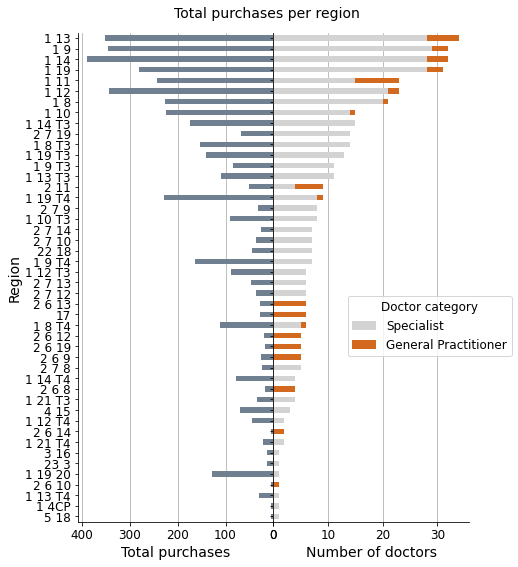


Correlation coef. -> 0.91


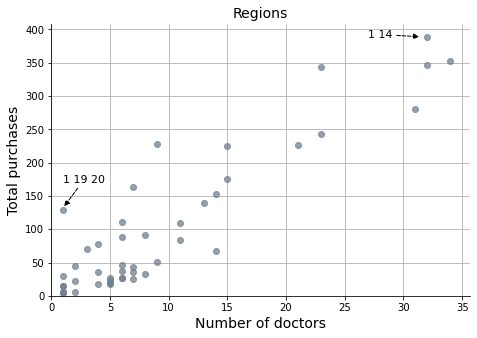

In [747]:
# Count categories of doctors by region
reg_cat = doctors.pivot_table(index='Region', columns='Category', values='DoctorID', aggfunc='count')

# Create new column with total doctors by region
reg_cat['total_docs'] = reg_cat.sum(axis=1)

# Sort by total number of doctors
reg_cat = reg_cat.sort_values('total_docs', ascending=False)

# Calculate purchase average by region
reg_pur_mean = doctors.pivot_table(index='Region', values='Purchases', aggfunc='mean')
reg_pur_mean = reg_pur_mean.rename(columns={'Purchases': 'purchases_mean'})

# Calculate purchase total by region
reg_pur_sum = doctors.pivot_table(index='Region', values='Purchases', aggfunc='sum')
reg_pur_sum = reg_pur_sum.rename(columns={'Purchases': 'purchases_sum'})

# Join tables on index
reg = reg_cat.join(reg_pur_sum).join(reg_pur_mean)


# Plot
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(7, 9))

fig.suptitle('Total purchases per region', fontsize=14, y=0.92)
plt.subplots_adjust(wspace=0)
sns.despine()

(-reg['purchases_sum']).plot(ax=ax[0], kind='barh', color='slategrey')
reg[['Specialist', 'General Practitioner']].plot(ax=ax[1], kind='barh',
                                                 stacked=True,
                                                 color=['lightgray', 'chocolate'])

for i in range(2):
    ax[i].grid(axis="x")
    ax[i].set_axisbelow(True)
    ax[i].set_ylabel('Region', fontsize=14)
    ax[i].tick_params(axis='x', labelsize=12, rotation=0)
    ax[i].tick_params(axis='y', labelsize=12)

ax[0].set_xlabel('Total purchases', fontsize=14)
ax[1].set_xlabel('Number of doctors', fontsize=14)

ax[0].invert_yaxis()

ax[1].legend(title='Doctor category',
             loc='center', bbox_to_anchor=(0.8, 0.4),
             title_fontsize=12, fontsize=12)

ax[0].set_xticks(list(range(0, -401, -100)), labels=list(range(0, 401, 100)))

plt.show()

print(f"\nCorrelation coef. -> {reg['total_docs'].corr(reg['purchases_sum']):.2f}")

# Plot scatter
fig, ax = plt.subplots(figsize=(7.5, 5))

ax.plot(reg['total_docs'], reg['purchases_sum'], marker='o', linestyle='none',
        alpha=0.75, color='slategrey')

sns.despine()
ax.grid(axis="both")
ax.set_axisbelow(True)
ax.set_title('Regions', fontsize=14)
ax.set_xlabel('Number of doctors', fontsize=14)
ax.set_ylabel('Total purchases', fontsize=14)

ax.annotate('1 19 20', xy=(1, 132), xytext=(1, 170), fontsize=11,
            arrowprops={"arrowstyle":"-|>", "color":"black", 'linestyle':"--"})
ax.annotate('1 14', xy=(31.5, 389), xytext=(27, 388), fontsize=11,
            arrowprops={"arrowstyle":"-|>", "color":"black", 'linestyle':"--"})

ax.set_xlim(0)
ax.set_ylim(0)

plt.show()

Customer segmentation is based on the region, and regions are likely sorted by the number of customers in each one of them. The graphs demonstrate a strong correlation between the total number of purchases and the number of customers-doctors.

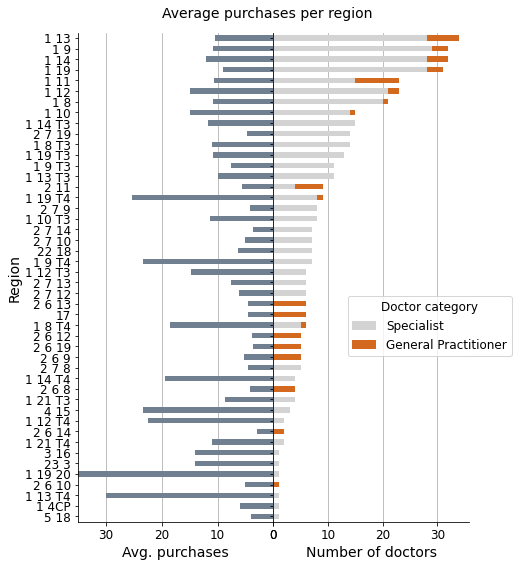


Correlation coef. -> -0.13


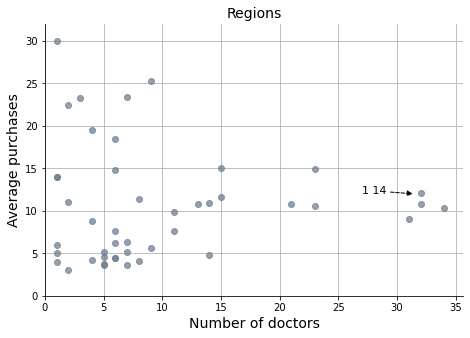

In [748]:
# Plot bar chart
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(7, 9))

fig.suptitle('Average purchases per region', fontsize=14, y=0.92)
plt.subplots_adjust(wspace=0)
sns.despine()

(-reg['purchases_mean']).plot(ax=ax[0], kind='barh', color='slategrey')
reg[['Specialist', 'General Practitioner']].plot(ax=ax[1], kind='barh',
                                                 stacked=True,
                                                 color=['lightgray', 'chocolate'])

for i in range(2):
    ax[i].grid(axis="x")
    ax[i].set_axisbelow(True)
    ax[i].set_ylabel('Region', fontsize=14)
    ax[i].tick_params(axis='x', labelsize=12, rotation=0)
    ax[i].tick_params(axis='y', labelsize=12)

ax[0].set_xlabel('Avg. purchases', fontsize=14)
ax[1].set_xlabel('Number of doctors', fontsize=14)

ax[0].invert_yaxis()

ax[1].legend(title='Doctor category',
             loc='center', bbox_to_anchor=(0.8, 0.4),
             title_fontsize=12, fontsize=12)

ax[0].set_xticks(list(range(0, -31, -10)), labels=list(range(0, 31, 10)))

ax[0].set_xlim(-35)

plt.show()

print(f"\nCorrelation coef. -> {reg['total_docs'].corr(reg['purchases_mean']):.2f}")

# Plot scatter
fig, ax = plt.subplots(figsize=(7.5, 5))

ax.plot(reg['total_docs'], reg['purchases_mean'], marker='o',
        linestyle='none', alpha=0.75, color='slategrey')

sns.despine()
ax.grid(axis="both")
ax.set_axisbelow(True)
ax.set_title('Regions', fontsize=14)
ax.set_xlabel('Number of doctors', fontsize=14)
ax.set_ylabel('Average purchases', fontsize=14)

ax.annotate('1 14', xy=(31.5, 12), xytext=(27, 12), fontsize=11,
            arrowprops={"arrowstyle":"-|>", "color":"black", 'linestyle':"--"})

ax.set_xlim(0)
ax.set_ylim(0, 32)

plt.show()

However, when considering *average* purchases, we can observe that the best customers are dispersed across various regions. This likely creates challenges in targeting specific marketing and sales campaigns based on the average purchasing history of customers.

### *Q2: Can you find a relationship between purchases and complaints?*

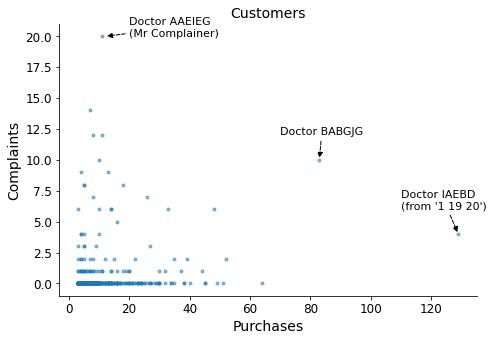

In [749]:
# Sum of complaints by doctor
doc_com = complaints.pivot_table(index='DoctorID', values='Qty', aggfunc='sum')
doc_com = doc_com.rename(columns={'Qty': 'complaints'})

# Merge with doctors table
doctors = doctors.merge(doc_com, how='left', on='DoctorID')
doctors = doctors.fillna({'complaints': 0})


# Plot
fig, ax = plt.subplots(figsize=(7.5, 5))

ax.plot(doctors['Purchases'], doctors['complaints'], marker='.', linestyle='none', alpha=0.5)

sns.despine()

ax.set_title('Customers', fontsize=14)
ax.set_xlabel('Purchases', fontsize=14)
ax.set_ylabel('Complaints', fontsize=14)

ax.tick_params(axis='x', labelsize=12, rotation=0)
ax.tick_params(axis='y', labelsize=12)

ax.annotate("Doctor IAEBD\n(from '1 19 20')", xy=(129, 4), xytext=(110, 6), fontsize=11,
            arrowprops={"arrowstyle":"-|>", "color":"black", 'linestyle':"--"})
ax.annotate("Doctor BABGJG", xy=(83, 10), xytext=(70, 12), fontsize=11,
            arrowprops={"arrowstyle":"-|>", "color":"black", 'linestyle':"--"})
ax.annotate("Doctor AAEIEG\n(Mr Complainer)", xy=(12, 20), xytext=(20, 20), fontsize=11,
            arrowprops={"arrowstyle":"-|>", "color":"black", 'linestyle':"--"})

plt.show()

To facilitate easier viewing and minimize their impact, I will remove the three outliers marked in the graph.


Correlation coef. -> 0.07



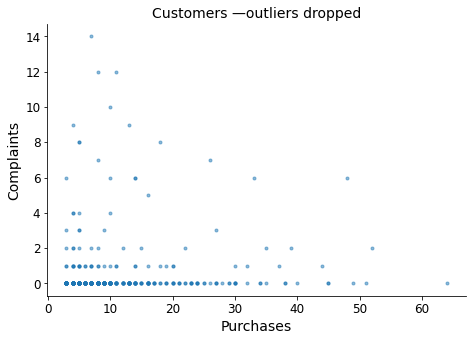

In [750]:
# Drop outliers
doctors = doctors.drop(doctors.loc[doctors['Purchases'] > 80, :].index)
doctors = doctors.drop(doctors.loc[doctors['complaints'] > 15, :].index)

# Print correlation coefficient
print(f"\nCorrelation coef. -> {doctors['complaints'].corr(doctors['Purchases']):.2f}\n")

# Plot
fig, ax = plt.subplots(figsize=(7.5, 5))

ax.plot(doctors['Purchases'], doctors['complaints'], marker='.', linestyle='none', alpha=0.5)

sns.despine()

ax.set_title('Customers —outliers dropped', fontsize=14)
ax.set_xlabel('Purchases', fontsize=14)
ax.set_ylabel('Complaints', fontsize=14)

ax.tick_params(axis='x', labelsize=12, rotation=0)
ax.tick_params(axis='y', labelsize=12)

plt.show()

There is no relationship between purchases and complaints. Knowing one does not allow us to deduce any information about the other.

### *Q3: Define new doctor segments that help the company improve marketing efforts and customer service.*

        Purchases  complaints
count  432.000000  432.000000
mean    10.375000    0.537037
std      9.344558    1.764175
min      3.000000    0.000000
25%      4.000000    0.000000
50%      7.000000    0.000000
75%     13.000000    0.000000
max     64.000000   14.000000


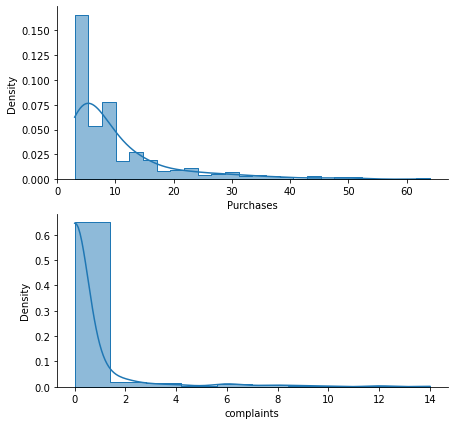

In [751]:
# Describe comparative statistics
print(doctors[['Purchases', 'complaints']].describe())

# Plot distributions
fig, ax = plt.subplots(2, 1, figsize=(7, 7))

sns.despine()
sns.histplot(doctors['Purchases'], ax=ax[0], kde=True, stat="density", element="step")
sns.histplot(doctors['complaints'], ax=ax[1], kde=True, stat="density", element="step")

plt.show()

I will proceed with a logarithmic transformation to manage data skewness. Afterward, I will standardize the data to prepare it for the K-Means algorithm.

In [752]:
# Data transformation to manage skewness
doctors_log = pd.DataFrame({'Purchases_log': np.log(doctors['Purchases']),
                            'Complaints_log': np.log(doctors['complaints'] +1)}) # To avoid log(0)!

# # Plot log transformed distributions
# fig, ax = plt.subplots(2, 1, figsize=(7, 7))
# 
# sns.histplot(doctors_log['Purchases_log'], ax=ax[0], kde=True, stat="density", element="step")
# sns.histplot(doctors_log['Complaints_log'], ax=ax[1], kde=True, stat="density", element="step")
# 
# plt.show()

# Initialize StandardScaler and fit it 
scaler = StandardScaler()
scaler.fit(doctors_log)

# Transform and store the scaled data as datamart_rfmt_normalized
doctors_normalized = scaler.transform(doctors_log)

# Construct a pandas data frame of normalized values for plotting later on
doctors_normalized_df = pd.DataFrame(doctors_normalized,
                                     index=doctors.index,
                                     columns=['Purchases', 'complaints'])

# Assign doctor ID
doctors_normalized_df = doctors_normalized_df.assign(DoctorID=doctors['DoctorID'])

# # Plot standardized distributions
# fig, ax = plt.subplots(2, 1, figsize=(7, 7))
# 
# sns.histplot(doctors_normalized[:, 0], ax=ax[0], kde=True, stat="density", element="step")
# sns.histplot(doctors_normalized[:, 1], ax=ax[1], kde=True, stat="density", element="step")
# 
# plt.show()

To determine the optimal number of clusters for K-Means, I will employ the elbow criterion method. For each number of clusters, I will calculate the sum of squared errors (SSE), which represents the sum of squared distances from each data point to its cluster center. By examining the chart, I will identify the elbow of the curve, which is the point where the SSE significantly levels off and becomes less substantial.

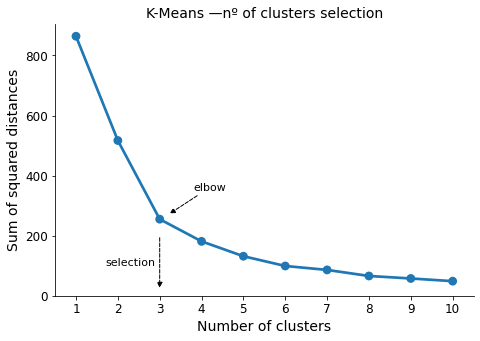

In [753]:
# Init
sse = {}

# Fit KMeans and calculate SSE for each k between 1 and 10
for k in range(1, 11):
  
    # Initialize KMeans with k clusters and fit it 
    kmeans = KMeans(n_clusters=k, random_state=1 ).fit(doctors_normalized)
    
    # Assign sum of squared distances to k element of the sse dictionary
    sse[k] = kmeans.inertia_   


# Plot
fig, ax = plt.subplots(figsize=(7.5, 5))

sns.pointplot(x=list(sse.keys()), y=list(sse.values()), ax=ax)

sns.despine()

ax.set_title('K-Means —nº of clusters selection', fontsize=14)
ax.set_xlabel('Number of clusters', fontsize=14)
ax.set_ylabel('Sum of squared distances', fontsize=14)

ax.tick_params(axis='x', labelsize=12, rotation=0)
ax.tick_params(axis='y', labelsize=12)

ax.set_ylim(0)

ax.annotate("elbow", xy=(2.2, 270), xytext=(2.8, 350), fontsize=11,
            arrowprops={"arrowstyle":"-|>", "color":"black", 'linestyle':"--"})
ax.annotate("", xy=(2, 20), xytext=(2, 200), fontsize=11,
            arrowprops={"arrowstyle":"-|>", "color":"black", 'linestyle':"--"})
ax.annotate("selection", xy=(2, 100), xytext=(0.7, 100), fontsize=11)

plt.show()

Number of clusters selected -> 3

In [754]:
# Initialize KMeans
kmeans = KMeans(n_clusters=3, random_state=1) 

# Fit k-means clustering on the normalized data set
kmeans.fit(doctors_normalized)

# Extract cluster labels
cluster_labels = kmeans.labels_

# Add a cluster label column
doctors = doctors.assign(Cluster=cluster_labels)

# Group by cluster
grouped = doctors.groupby(['Cluster'])

# Calculate average values and segment sizes for each cluster
grouped.agg({
    'Purchases': 'mean',
    'complaints': ['mean', 'count']
  }).round(1)

Purchases complaints      
             mean       mean count
Cluster                           
0             5.3        0.1   258
1            11.2        5.4    36
2            19.6        0.2   138

In the table, we can already observe distinct differences among the three clusters. Cluster 1 exhibits a higher mean value for complaints, while cluster 2 demonstrates a higher average for purchases.

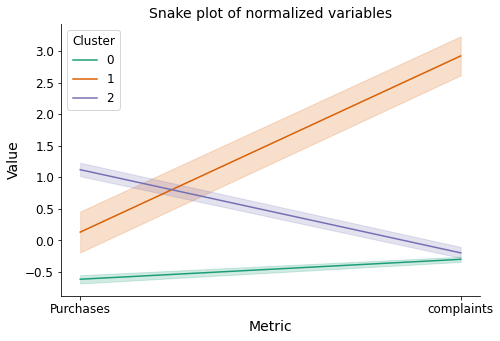

In [755]:
# Create a new DataFrame by adding a cluster label column to datamart_rfmt
doctors_normalized_df = doctors_normalized_df.assign(Cluster=cluster_labels)

# Melt the normalized dataset and reset the index
doctors_normalized_df_melt = pd.melt(doctors_normalized_df, 
                         id_vars=['DoctorID', 'Cluster'],
                         value_vars=['Purchases', 'complaints'], 
                         var_name='Metric', value_name='Value')

# Plot
fig, ax = plt.subplots(figsize=(7.5, 5))

# Define color palette to identify each cluster
palette='Dark2'

sns.lineplot(data=doctors_normalized_df_melt, x='Metric', y='Value',
             hue='Cluster', palette=palette)

sns.despine()

ax.set_title('Snake plot of normalized variables', fontsize=14)
ax.set_xlabel('Metric', fontsize=14)
ax.set_ylabel('Value', fontsize=14)

ax.tick_params(axis='x', labelsize=12, rotation=0)
ax.tick_params(axis='y', labelsize=12)

ax.legend(title='Cluster', title_fontsize=12, fontsize=12)

plt.show()

The snake plot of the normalized variables allows us to clearly observe the aforementioned differences between the clusters.

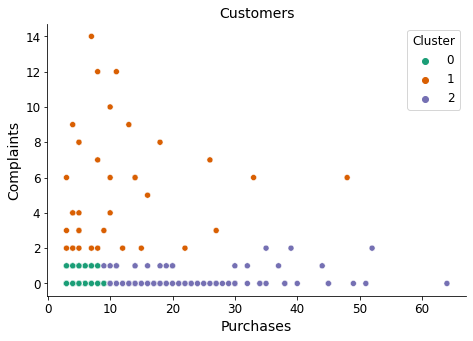

In [756]:
# Plot
fig, ax = plt.subplots(figsize=(7.5, 5))

sns.scatterplot(x='Purchases', y='complaints', data=doctors, ax=ax,
                hue='Cluster', hue_order=[0, 1, 2],
                palette=palette, alpha=1)

sns.despine()

ax.set_title('Customers', fontsize=14)
ax.set_xlabel('Purchases', fontsize=14)
ax.set_ylabel('Complaints', fontsize=14)

ax.tick_params(axis='x', labelsize=12, rotation=0)
ax.tick_params(axis='y', labelsize=12)

ax.legend(title='Cluster', title_fontsize=12, fontsize=12)

plt.show()

Finally, we revisit the scatter plot where we previously observed no relationship between variables. This time, each cluster is assigned a distinct color for easier identification. Additionally, I will assign descriptive names to each cluster:

- *Cluster 1* -> **complainers** (due to their higher average of complaints)
- *Cluster 2* -> **purchasers** (due to their higher average of purchases)
- *Cluster 0* -> **lowers** (simply a descriptive name, not indicating high purchases or complaints)

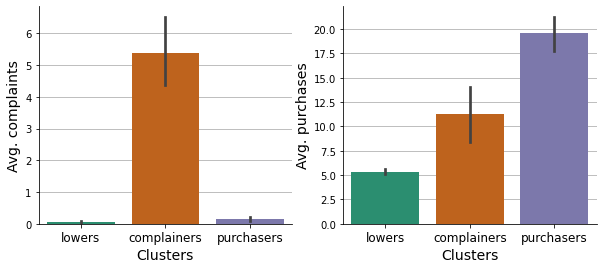

In [757]:
# Replace cluster numbers by intuitive names
doctors['Cluster'] = doctors['Cluster'].replace({0: 'lowers', 1: 'complainers', 2: 'purchasers'})

# Define the order to plot
order=['lowers', 'complainers', 'purchasers']

# Plot
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
sns.despine()
sns.barplot(x='Cluster', y='complaints', data=doctors, ax=ax[0], order=order, palette=palette)
sns.barplot(x='Cluster', y='Purchases', data=doctors, ax=ax[1], order=order, palette=palette)

for i in range(2):
    ax[i].grid(axis="y")
    ax[i].set_axisbelow(True)
    ax[i].set_xlabel('Clusters', fontsize=14)
    ax[i].tick_params(axis='x', labelsize=12, rotation=0)

ax[0].set_ylabel('Avg. complaints', fontsize=14)
ax[1].set_ylabel('Avg. purchases', fontsize=14)

plt.show()

These graphs serve to confirm the meaningfulness of the descriptive names that were assigned.

### *Q4: Identify which features impact the new segmentation strategy the most.*

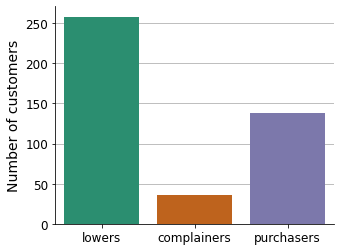

In [758]:
# Plot
fig, ax = plt.subplots(figsize=(5, 4))
sns.despine()

sns.countplot(x='Cluster', data=doctors, order=order, palette=palette, ax=ax)

ax.grid(axis="y")
ax.set_axisbelow(True)
ax.set_title('', fontsize=14)
ax.set_xlabel('', fontsize=14)
ax.set_ylabel('Number of customers', fontsize=14)

ax.tick_params(axis='x', labelsize=12, rotation=0)
ax.tick_params(axis='y', labelsize=12)

plt.show()

The new segmentation strategy imbalances the number of customers.

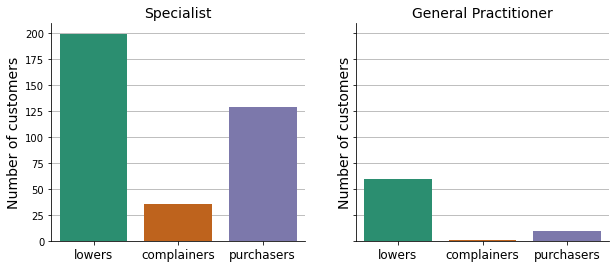

In [759]:
# Plot
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(10, 4))
sns.despine()

sns.countplot(x='Cluster', data=doctors.loc[doctors['Category'] == 'Specialist', :],
              order=order, palette=palette, ax=ax[0])
sns.countplot(x='Cluster', data=doctors.loc[doctors['Category'] == 'General Practitioner', :],
              order=order, palette=palette, ax=ax[1])

for i in range(2):
    ax[i].grid(axis="y")
    ax[i].set_axisbelow(True)
    ax[i].set_xlabel('', fontsize=14)
    ax[i].set_ylabel('Number of customers', fontsize=14)
    ax[i].tick_params(axis='x', labelsize=12, rotation=0)

ax[0].set_title('Specialist', fontsize=14)
ax[1].set_title('General Practitioner', fontsize=14)

plt.show()

Almost all complainers and the great majority of purchasers come from specialist doctors.

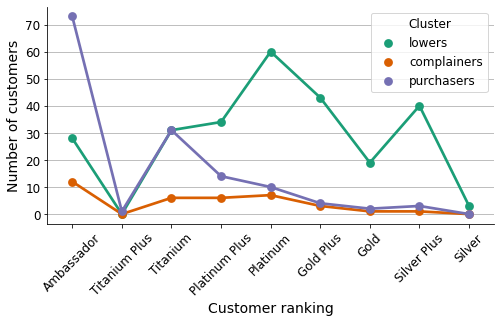

In [760]:
# Group clusters by Rank, then melt for plotting
by_rank = doctors.pivot_table(index='Rank', columns='Cluster',
                              values='DoctorID', aggfunc='count')\
            .reset_index().melt(id_vars='Rank',
                                value_vars=['complainers', 'lowers', 'purchasers'])\
            .sort_values('Rank')

# Plot
fig, ax = plt.subplots(figsize=(8, 4))
sns.despine()

sns.pointplot(x='Rank', y='value', data=by_rank, ax=ax,
              hue='Cluster', hue_order=order, palette=palette)

ax.grid(axis="y")
ax.set_axisbelow(True)
ax.set_title('', fontsize=14)
ax.set_xlabel('Customer ranking', fontsize=14)
ax.set_ylabel('Number of customers', fontsize=14)

ax.tick_params(axis='x', labelsize=12, rotation=45)
ax.tick_params(axis='y', labelsize=12)

ax.legend(title='Cluster', title_fontsize=12, fontsize=12)

plt.show()

This graph illustrates the distribution of customers from each cluster in relation to the internal ranking of the company.

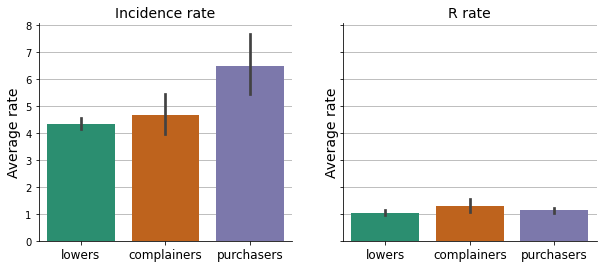

In [761]:
# Plot
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(10, 4))
sns.despine()

sns.barplot(x='Cluster', y='Incidence rate', data=doctors,
              order=order, palette=palette, ax=ax[0])
sns.barplot(x='Cluster', y='R rate', data=doctors,
              order=order, palette=palette, ax=ax[1])

for i in range(2):
    ax[i].grid(axis="y")
    ax[i].set_axisbelow(True)
    ax[i].set_xlabel('', fontsize=14)
    ax[i].set_ylabel('Average rate', fontsize=14)
    ax[i].tick_params(axis='x', labelsize=12, rotation=0)

ax[0].set_title('Incidence rate', fontsize=14)
ax[1].set_title('R rate', fontsize=14)

plt.show()

The amount of re-work each doctor generates.

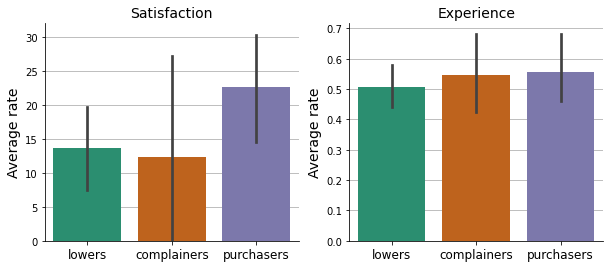

In [762]:
# Plot
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
sns.despine()

sns.barplot(x='Cluster', y='Satisfaction', data=doctors,
              order=order, palette=palette, ax=ax[0])
sns.barplot(x='Cluster', y='Experience', data=doctors,
              order=order, palette=palette, ax=ax[1])

for i in range(2):
    ax[i].grid(axis="y")
    ax[i].set_axisbelow(True)
    ax[i].set_xlabel('', fontsize=14)
    ax[i].set_ylabel('Average rate', fontsize=14)
    ax[i].tick_params(axis='x', labelsize=12, rotation=0)
    ax[i].set_ylim(0)

ax[0].set_title('Satisfaction', fontsize=14)
ax[1].set_title('Experience', fontsize=14)

plt.show()

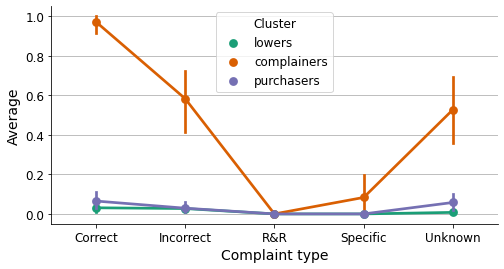

In [763]:
# Group complaint types by doctor
doc_comtype = complaints.pivot_table(index='DoctorID', columns='Complaint Type',
                                     values='Qty', aggfunc='count')

# Merge with doctors table
doctors = doctors.merge(doc_comtype, how='left', on='DoctorID')
doctors = doctors.fillna({'Correct': 0, 'Incorrect': 0,
                          'R&R': 0, 'Specific': 0, 'Unknown': 0})

# Merge instructions with doctors table
doctors = doctors.merge(instructions, how='left', on='DoctorID')
doctors = doctors.fillna({'Instructions': 0})

# Adapt data frame to plot
by_complaint = doctors.loc[:, ['Cluster', 'Correct', 'Incorrect', 'R&R', 'Specific', 'Unknown']]\
.melt(id_vars='Cluster', value_vars=['Correct', 'Incorrect', 'R&R', 'Specific', 'Unknown'])


# Plot
fig, ax = plt.subplots(figsize=(8, 4))
sns.despine()

sns.pointplot(x='variable', y='value', data=by_complaint, ax=ax,
              hue='Cluster', hue_order=order, palette=palette)

ax.grid(axis="y")
ax.set_axisbelow(True)
ax.set_title('', fontsize=14)
ax.set_xlabel('Complaint type', fontsize=14)
ax.set_ylabel('Average', fontsize=14)

ax.tick_params(axis='x', labelsize=12, rotation=0)
ax.tick_params(axis='y', labelsize=12)

ax.legend(title='Cluster', title_fontsize=12, fontsize=12)

plt.show()

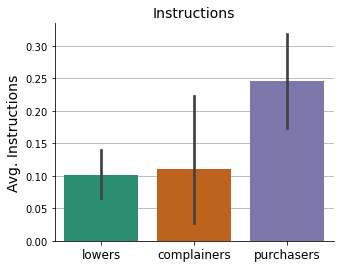

In [764]:
# Plot
fig, ax = plt.subplots(figsize=(5, 4))
sns.despine()

sns.barplot(x='Cluster', y='Instructions', data=doctors,
              order=order, palette=palette, ax=ax)

ax.grid(axis="y")
ax.set_axisbelow(True)
ax.set_xlabel('', fontsize=14)
ax.set_ylabel('Avg. Instructions', fontsize=14)
ax.tick_params(axis='x', labelsize=12, rotation=0)

ax.set_title('Instructions', fontsize=14)


plt.show()

## Conclusions
In this project, a new customer segmentation strategy was proposed, taking into account customer purchasing and complaining rates. This classification approach would assist the company in addressing marketing and sales activities with greater precision, as well as improving customer service and support.